### Using Kernel Ridge Regression to fit a Coulomb Matrix

Creating a model to predict the highest occupied molecular orbital energy, plotting a learning curve, and optimizing its training set!

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from dscribe.descriptors import CoulombMatrix
from ase.io.xyz import read_xyz
from io import StringIO
import pandas as pd
import numpy as np    # loading all necessary functions

#### Preprocessing!

In [2]:
# loading qm9 dataset

data = pd.read_json('../datasets/qm9.json.gz', lines=True)

In [3]:
data ['atoms'] = data['xyz'].map(lambda x: next(read_xyz(StringIO(x), slice(None)))) # converting 3D coordinates of each atom into string-like object 

#### Computing Coulomb's matrix for all molecules that have less than 40 atoms

In [4]:
# computing Coulomb's Matrix for each entry, maximum entries of 40

cm = CoulombMatrix(40, permutation="eigenspectrum", flatten=False)
x = cm.create(data['atoms'], n_jobs=2)

data['cm'] = x.tolist() # converting Coulomb Matrix into a python list

#### Creating and fitting a Kernel Ridge model along with GridSearchCV to analyze variations of all hyperparameters over 16 iterations

In [5]:
# creating model using Kernel Ridge + RBF kernel w/ GridSearchCV to predict highest occupied molecular orbital energy + fitting model 16 times

results = []
num_iterations = 16 

for i in range(num_iterations): 
    train_data, test_data = train_test_split(data, test_size=1000, train_size=100)

    model = Pipeline([
        ('scale', StandardScaler()), 
        ('krr', KernelRidge(kernel='rbf'))
    ])

    gs = GridSearchCV(
        model, 
        {'krr__gamma': np.logspace(-6, 0, 16), 'krr__alpha': np.logspace(-6, 0, 16)}, 
        cv = 10,
        scoring= 'neg_mean_squared_error'
    )

    gs.fit(np.vstack(train_data['cm']), train_data['u0_atom'])
    model = gs.best_estimator_
    model.fit(np.vstack(train_data['cm']), train_data['u0_atom'])
    y_pred = model.predict(np.vstack(test_data['cm']))
    
    # saving results (issue: appending dictionary to dataframe causes errors)
    
    results.append({
        'gamma': gs.best_params_['krr__gamma'],
        'alpha': gs.best_params_['krr__alpha'],
        'mae': mean_absolute_error(y_pred, test_data['u0_atom'])
    })
      

In [6]:
results = pd.DataFrame(results)

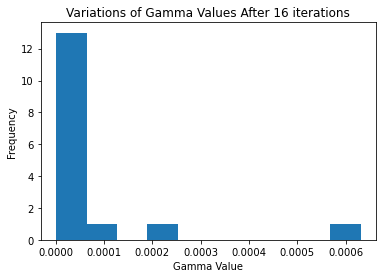

In [7]:
# variations of gamma parameter as data subsets change
plt.hist(results['gamma'])
plt.title('Variations of Gamma Values After 16 iterations')
plt.xlabel('Gamma Value')
plt.ylabel('Frequency')
plt.show()

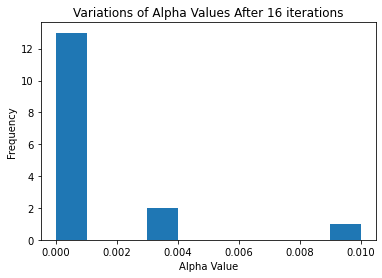

In [8]:
# variations of alpha parameter as data subsets change
plt.hist(results['alpha'])
plt.title('Variations of Alpha Values After 16 iterations')
plt.xlabel('Alpha Value')
plt.ylabel('Frequency')
plt.show()

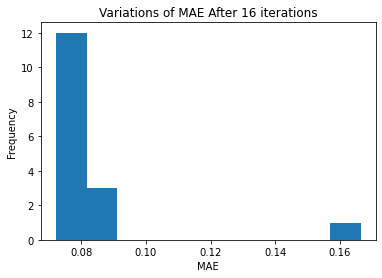

In [9]:
# variations of mae as data subsets change
plt.hist(results['mae'])
plt.title('Variations of MAE After 16 iterations')
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.show()

#### Computing a learning curve analyzing the impact of training set size on model accuracy, training time, and inference times!

In [10]:
# setting up three different training sizes for learning curve
train_size = [10, 100, 1000]

# setting up general test and training sets

train_data, test_data = train_test_split(data, test_size=1000, random_state=1)
test_data = test_data.copy()

# repeating fitting four times for each training size 
num_iterations = 4

# importing time function to measure train + test time
from time import perf_counter

# setting up model pipeline WITH GridSearch CV

model = Pipeline([
        ('scale', StandardScaler()), 
        ('krr', KernelRidge(kernel='rbf'))
    ])

gs = GridSearchCV(
        model, 
        {'krr__gamma': np.logspace(-6, 0, 16), 'krr__alpha': np.logspace(-6, 0, 16)}, 
        cv = 10,
        scoring= 'neg_mean_squared_error'
    )

# importing tqdm function
from tqdm import tqdm

In [11]:
results = []
for i in range(num_iterations):
    for ts in tqdm(train_size): 
        # changing training data size
        train_subset = train_data.sample(ts, random_state=1)

        # measuring train time
        train_time = perf_counter()
        gs.fit(np.vstack(train_subset['cm']), train_subset['u0_atom'])
        model = gs.best_estimator_
        model.fit(np.vstack(train_subset['cm']), train_subset['u0_atom'])
        train_time = perf_counter() - train_time

        # measuring test/inference time
        test_time = perf_counter()
        y_pred = model.predict(np.vstack(test_data['cm']))
        test_time = perf_counter() - test_time

        # storing results
        results.append({
            'train_size': ts,
            'train_time': train_time,
            'test_time': test_time,
            'mae': mean_absolute_error(y_pred, test_data['u0_atom'])
        })
            

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:19<00:00, 26.44s/it]


In [12]:
results = pd.DataFrame(results)

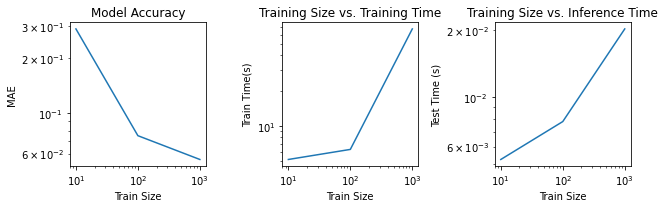

In [13]:
# graphing change of MAE as training size increases

fig, axs = plt.subplots(1, 3, figsize=(9, 3.))
avg_data = results.groupby('train_size').mean()

ax = axs[0]
ax.loglog(avg_data.index, avg_data['mae'])
ax.set_xlabel('Train Size')
ax.set_ylabel('MAE')
ax.set_title('Model Accuracy')

# graphing change of training time as training size increases

ax = axs[1]
ax.loglog(avg_data.index, avg_data['train_time'])
ax.set_xlabel('Train Size')
ax.set_ylabel('Train Time(s)')
ax.set_title('Training Size vs. Training Time')

# graphing change in inference time as training size increases

ax = axs[2]
ax.loglog(avg_data.index, avg_data['test_time'])
ax.set_xlabel('Train Size')
ax.set_ylabel('Test Time (s)')
ax.set_title('Training Size vs. Inference Time')

fig.tight_layout()

### Optimizing Training Data Using Genetic Algorithms

In [14]:
# separating out validation set from training set

valid_data = train_data.sample(1000)

# creating function to quickly produce score of model based on indices of inputted points

def evaluate_subset(points: list, model, train_data: pd.DataFrame, test_data: pd.DataFrame) -> float: 
    """Test a subset of points
    
    Args:
        points: Which points from the train_data to sample
        model: Model to use for testing
        train_data: All available training points
        test_data: Data used to test the model
    Returns:
        MAE on the test set
    """
    # getting training data based on indices
    train_subset = train_data.iloc[points]
    
    # fitting the model
    model = model.fit(np.vstack(train_subset['cm']), train_subset['u0_atom'])
    
    # predicting points
    y_pred = model.predict(np.vstack(test_data['cm']))
    
    # producing score of model
    mae = mean_absolute_error(y_pred, test_data['u0_atom'])
    
    return mae

Note: the following genetic algorithm was used from an outside source (just wanted to see whether or not implementing a genetic algorithm would improve the model performance)

In [15]:
import random
from random import sample

def mutate(points: set, total: int, fraction: float = 0.1) -> set:    
    """Mutate a set of points
    
    Mutates from selecting points randomly from the dataset
    
    Args:
        points: Set of points to be mutated
        total: Total number of samples to choose from in dataset
        fraction: How many points to re-select
    """
    
    # Remove the desired amount of points
    n_to_remove = int(len(points) * fraction)
    to_remove = sample(points, k=n_to_remove)
    new_points = points.difference(to_remove)
    
    # Add more points to the set
    available_choices = set(range(total)).difference(new_points)
    new_points.update(sample(available_choices, n_to_remove))
    
    return new_points

def crossover(parent_a: set, parent_b: set):
    """Perform a crossover operation
    
    Randomly chooses points from both parents
    
    Args:
        parent_a: One choice of points
        parent_b: Another choice of points
    Returns:
        A new set that combines both parents
    """
    
    # Combine all points from each parents
    options = parent_a.union(parent_b)
    
    # Pick randomly from the combined set
    return set(sample(options, len(parent_a)))

In [16]:
%%capture
# Defining options
n_generations = 50
pop_size = 8
dataset_size = 100

# Array in which to store all results
all_options = []

# Make an initial population
#  Creates sets where each have different entries pull from the full dataset
population = np.array([set(sample(range(len(train_data)), k=100)) for i in range(pop_size)])

# Loop over the generations
for gen in tqdm(range(n_generations), desc='generation'):
    # Score each member of the population
    scores = [
        evaluate_subset(list(s), gs, train_data, valid_data) for s 
        in population
    ]
    
    # Store the results in the history
    for i, s in enumerate(population):
        all_options.append({
            'generation': gen,
            'points': s,
            'score': scores[i]
        })
        
    # Sort scores and pick the best quarter
    ranks = np.argsort(scores)
    best_members = population[ranks[:pop_size // 4]]
    
    # Create new members by crossover and mutation
    new_population = []
    for i in range(pop_size):
        # Pick two parents at random
        parent_a, parent_b = random.sample(best_members.tolist(), 2)
        
        # Form a new member by crossover
        new_member = crossover(parent_a, parent_b)
        
        # Mutate it for good measure
        new_population.append(
            mutate(new_member, total=len(train_data))
        )
    
    # Replace population with new population
    population = np.array(new_population)

Text(0.5, 1.0, 'Best Scores as a Function of Generation')

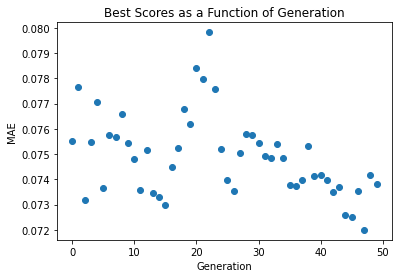

In [17]:
# plotting best score as a function of generation

# converting all_options into a dataframe
all_options = pd.DataFrame(all_options)

# finding best score for each generation

best_scores = all_options.groupby('generation')['score']
best_scores = best_scores.aggregate(['min'])

# plotting points for each generation
fig, ax = plt.subplots()
plt.scatter(best_scores.index, best_scores)
ax.set_xlabel('Generation')
ax.set_ylabel('MAE')
ax.set_title('Best Scores as a Function of Generation')

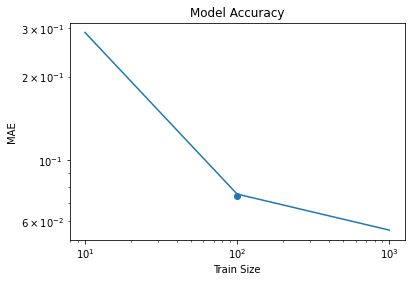

In [18]:
# graphing change of MAE as training size increases

fig, ax = plt.subplots()
avg_data = results.groupby('train_size').mean()

ax.loglog(avg_data.index, avg_data['mae'])
ax.set_xlabel('Train Size')
ax.set_ylabel('MAE')
ax.set_title('Model Accuracy')

plt.scatter(100, best_scores.iloc[49]['min'])

#### Conclusions: 

1. Hyperparameters slightly change as we change the training subsets in order to minimize mean absolute error and maximize model accuracy, emphasizing the importance of always using hyperparameter optimization when refitting models!

2. Genetic algorithms slightly improves model performance when compared with the mean absolute error of the model without the optimized training set. 